# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *** *Under construction* ***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from monte_carlo.monte_carlo import MonteCarlo

Suppose we have a matrix of data
$\boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1})$,
where
$\boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting distributions to perform a MonteCarlo-like simulation of the input data.

The implementation is put in [`monte_carlo.py`](monte_carlo/monte_carlo.py).

# Use MonteCarlo class

In [2]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL', 'FRO.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,17.060759,668.643738,1216.948120,10.964588,18.962236,22.093430
2004-03-26 00:00:00+01:00,17.216923,670.436035,1199.807983,10.977160,19.238770,22.526638
2004-03-29 00:00:00+02:00,17.255962,702.703125,1216.948120,10.914293,19.712822,21.985136
2004-03-30 00:00:00+02:00,17.177877,700.910645,1222.661499,10.826274,18.646196,21.660231
2004-03-31 00:00:00+02:00,17.568291,699.117798,1199.807983,10.863995,18.804209,21.573587
...,...,...,...,...,...,...
2023-11-06 00:00:00+01:00,199.000000,250.000000,9.620000,63.779999,116.449997,367.000000
2023-11-07 00:00:00+01:00,198.449997,241.899994,9.410000,61.720001,115.900002,359.700012
2023-11-08 00:00:00+01:00,198.949997,239.399994,9.700000,62.380001,114.599998,368.899994


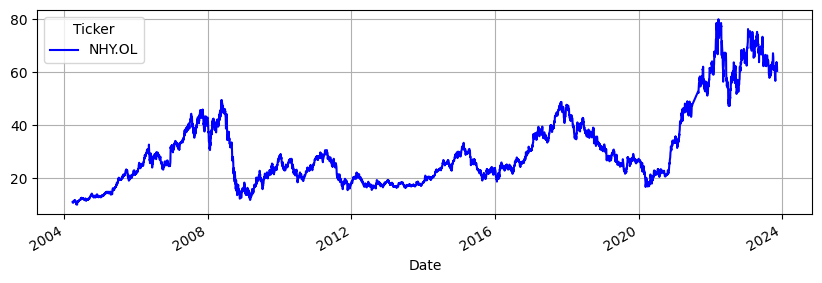

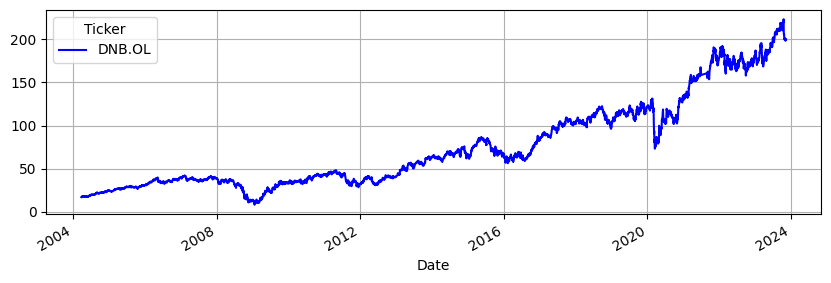

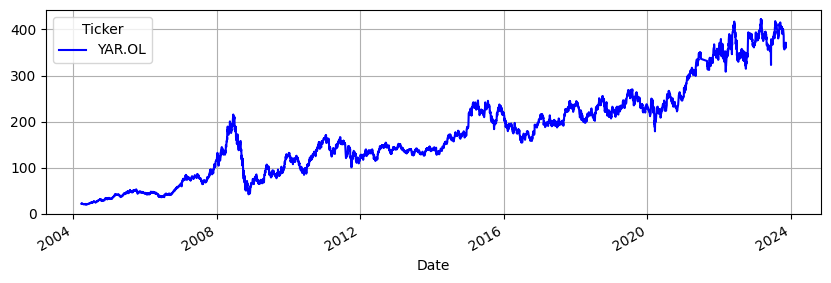

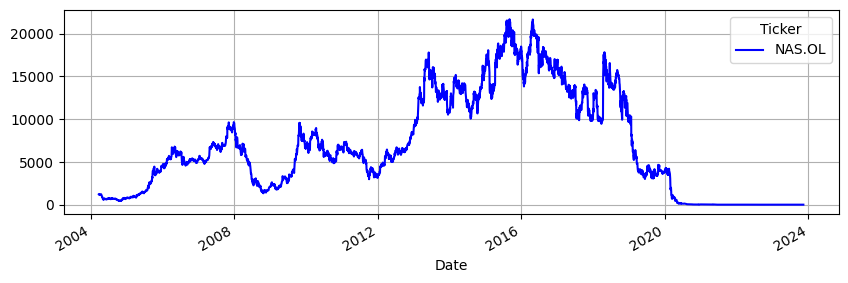

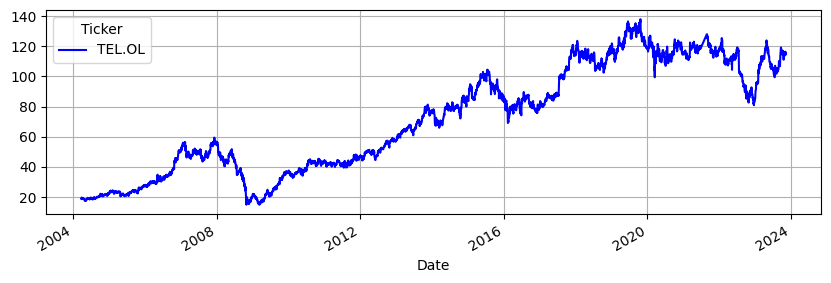

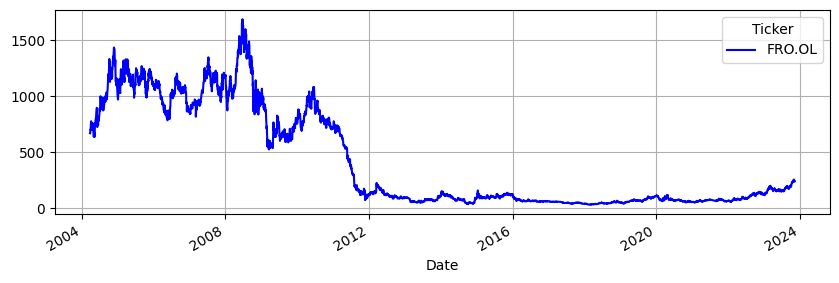

In [3]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [4]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-26 00:00:00+01:00,0.009112,0.002677,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,0.004684,-0.008097,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.002561,-0.018869,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,0.042667,-0.014389,-0.005804,-0.004210,0.004008
...,...,...,...,...,...,...
2023-11-06 00:00:00+01:00,0.000251,0.004008,0.005002,0.011353,0.004303,-0.003264
2023-11-07 00:00:00+01:00,-0.002768,-0.032937,-0.022071,-0.032832,-0.004734,-0.020091
2023-11-08 00:00:00+01:00,0.002516,-0.010389,0.030353,0.010637,-0.011280,0.025255


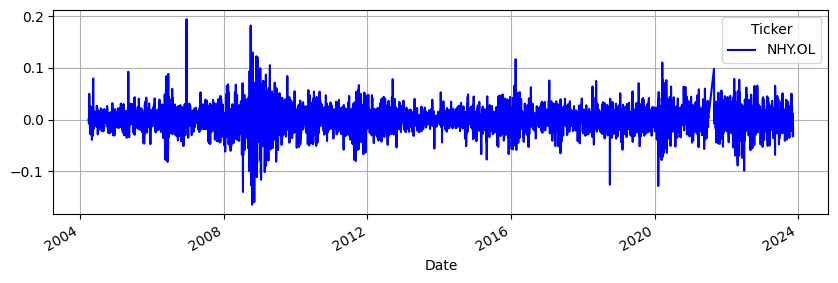

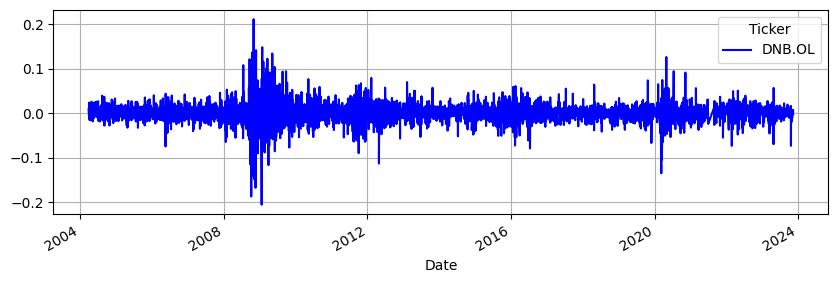

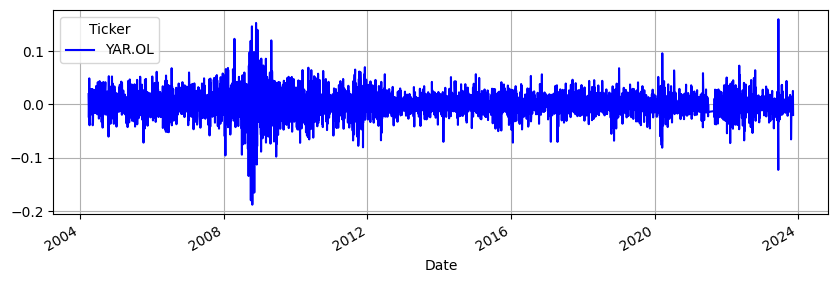

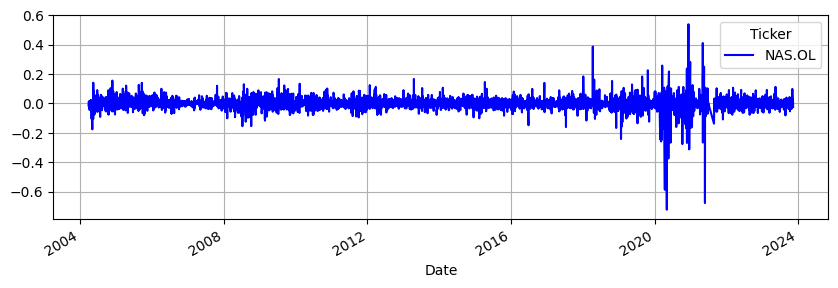

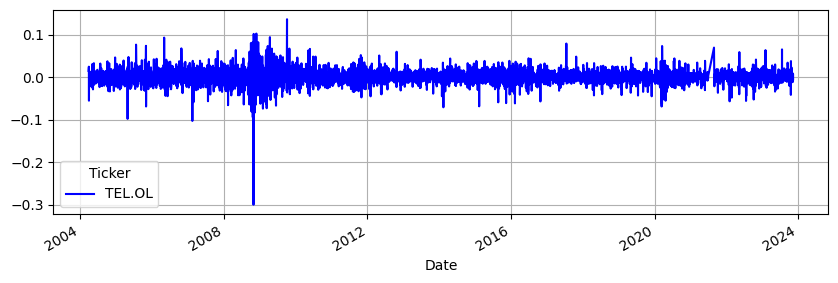

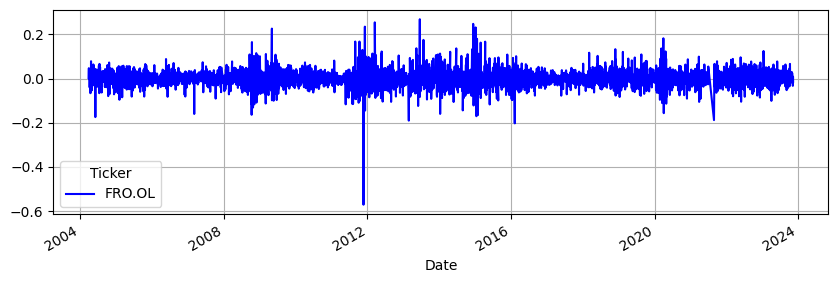

In [5]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [6]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.253371,0.194725,0.482178,0.388539,0.418122
FRO.OL,0.253371,1.000000,0.124595,0.315773,0.197061,0.277824
NAS.OL,0.194725,0.124595,1.000000,0.203100,0.152877,0.167619
NHY.OL,0.482178,0.315773,0.203100,1.000000,0.353154,0.487887
TEL.OL,0.388539,0.197061,0.152877,0.353154,1.000000,0.346645
YAR.OL,0.418122,0.277824,0.167619,0.487887,0.346645,1.000000


In [7]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
1,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000
2,-0.000000,-0.000000,1.000000,0.000000,0.000000,-0.000000
3,0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000
4,-0.000000,-0.000000,0.000000,0.000000,1.000000,-0.000000
5,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000


In [8]:
# The normalized ones are nearly orthogonal too
fit.norm_orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999474,0.086483,0.034139,0.022830,0.013340,-0.014920
1,0.086483,1.000331,0.050552,0.014617,0.002807,-0.018711
2,0.034139,0.050552,1.000173,-0.018901,-0.038732,0.049804
3,0.022830,0.014617,-0.018901,1.000853,-0.031402,0.008871
4,0.013340,0.002807,-0.038732,-0.031402,1.000491,0.065971
5,-0.014920,-0.018711,0.049804,0.008871,0.065971,1.000755


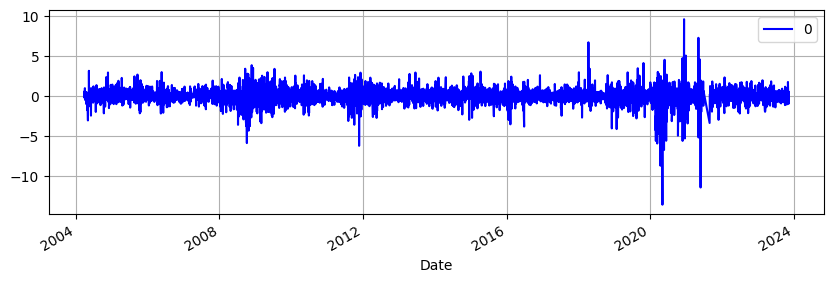

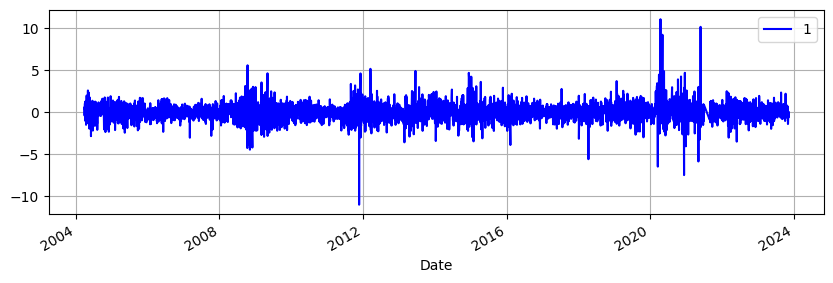

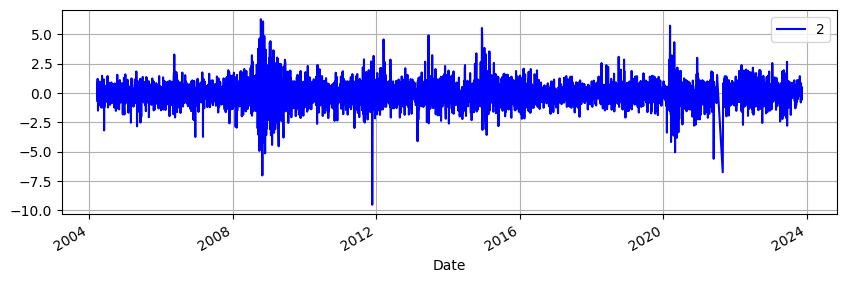

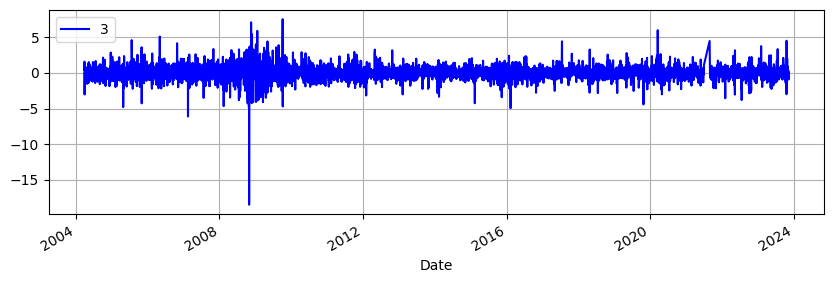

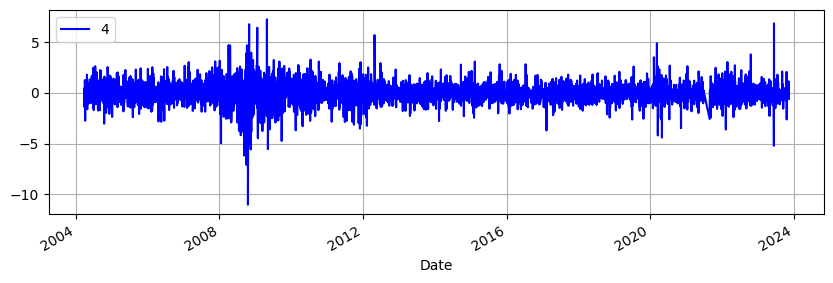

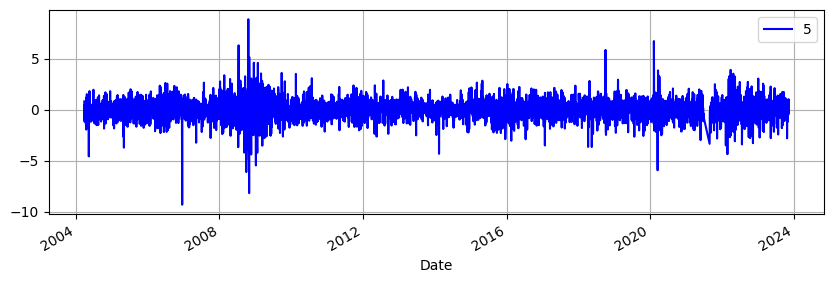

In [9]:
# Orthogonal disturbances
for col in fit.orthog_disturbances_df.columns:
    fit.orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

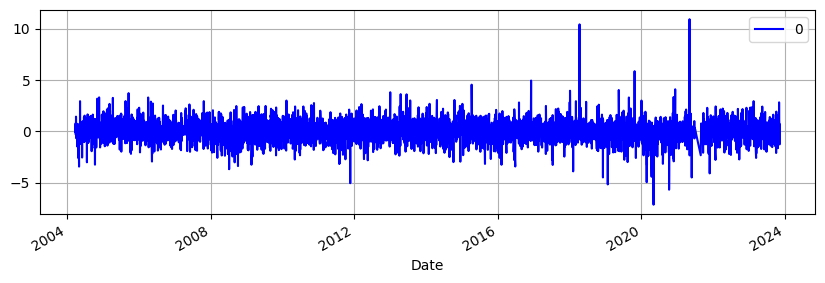

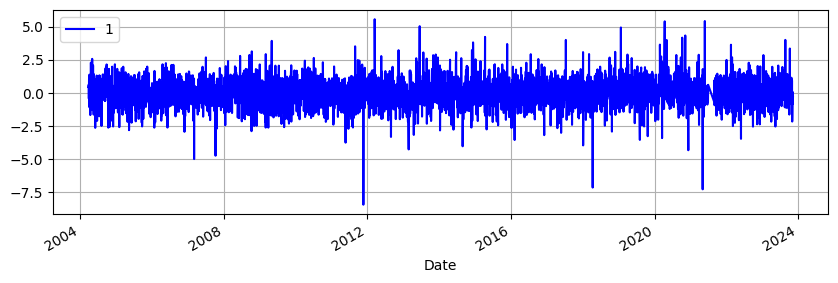

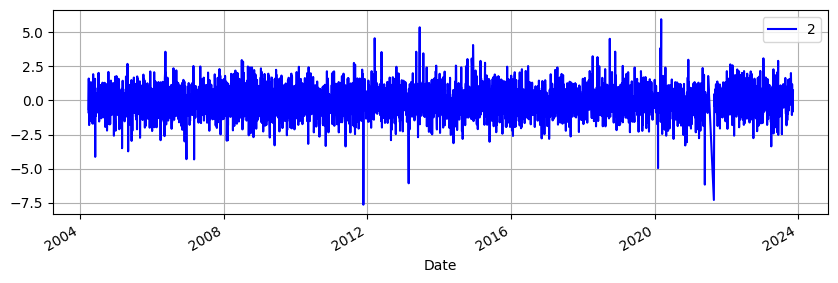

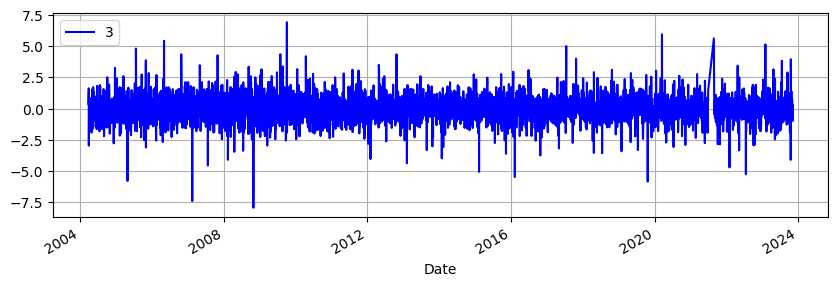

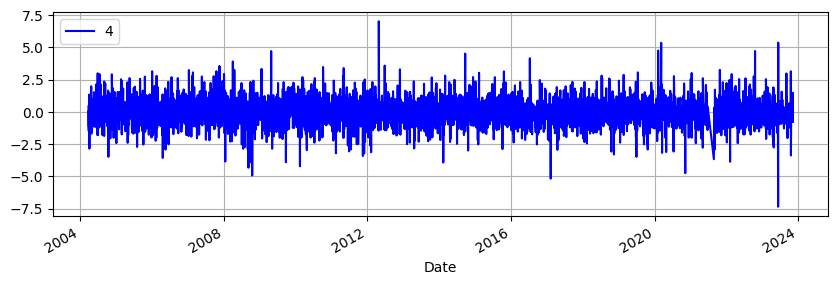

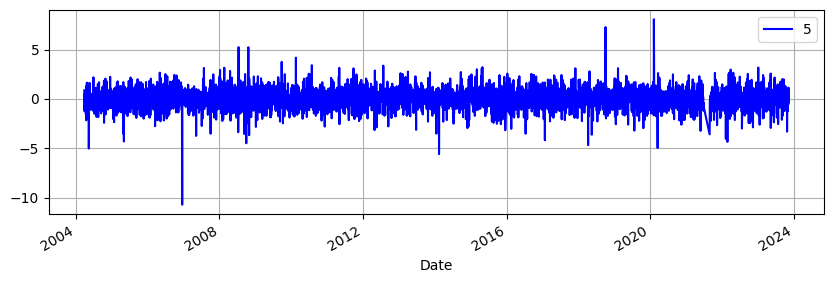

In [10]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for col in fit.orthog_disturbances_df.columns:
    fit.norm_orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

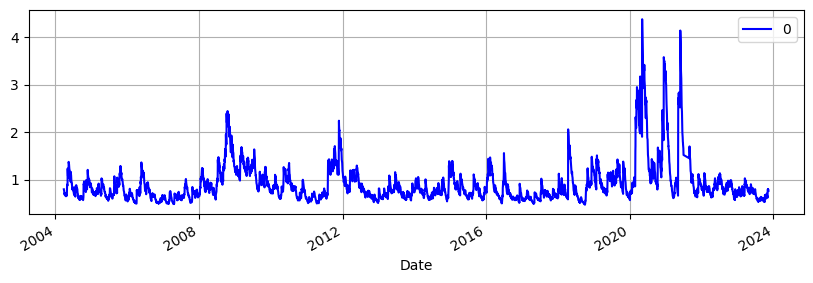

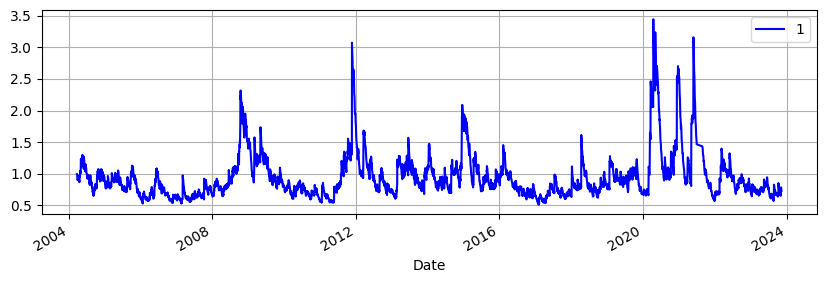

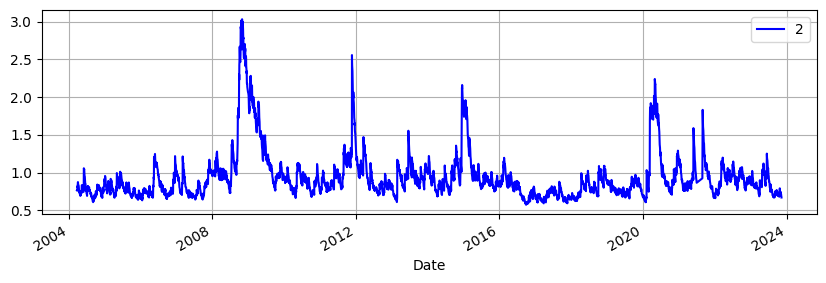

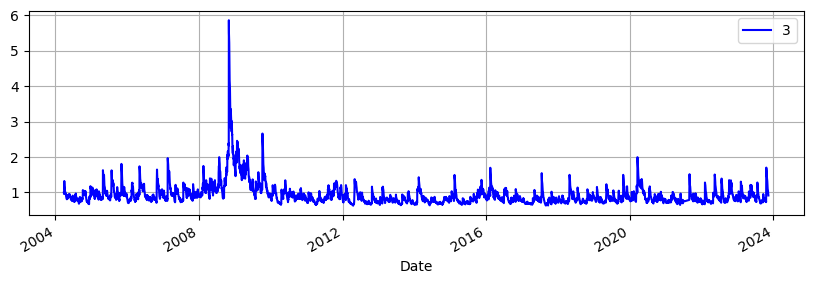

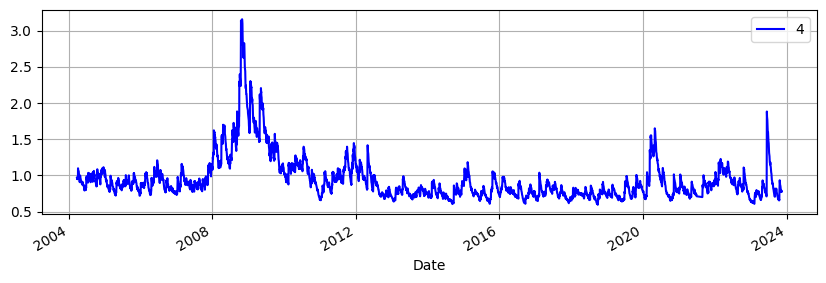

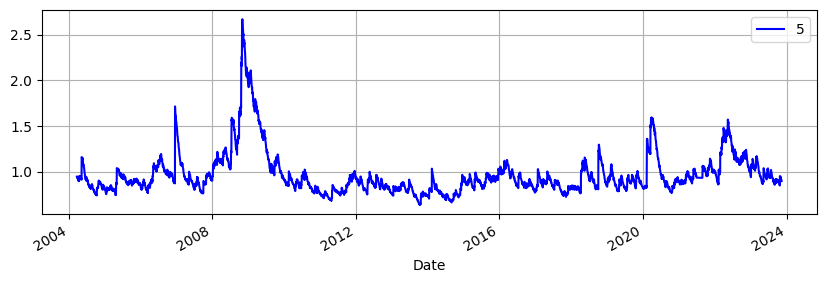

In [11]:
for col in fit.conditional_volatility_df.columns:
    fit.conditional_volatility_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

In [34]:
n_periods = 100
n_simulations = 100

# Store forecast in dict
forecast = fit.forecast(100, 100)

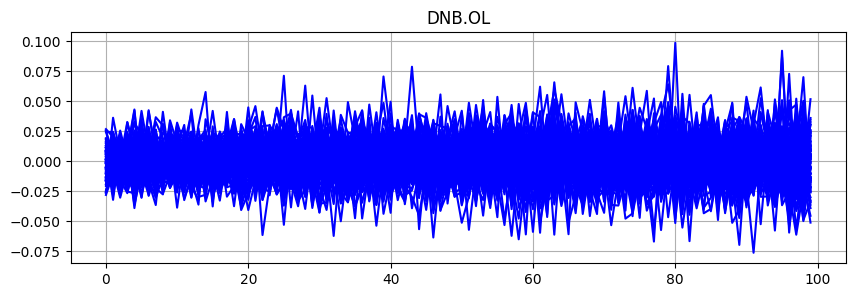

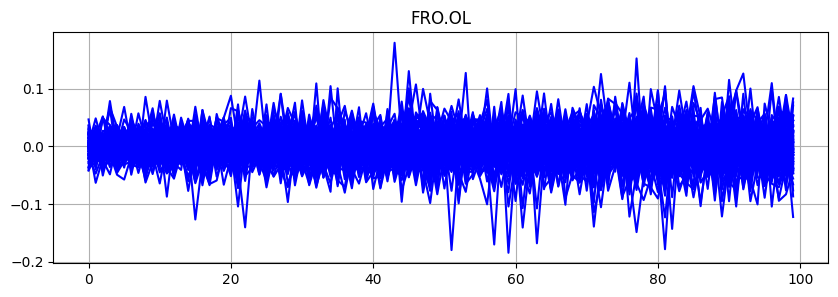

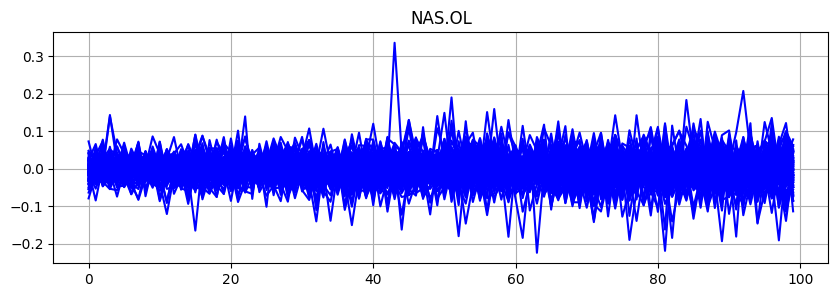

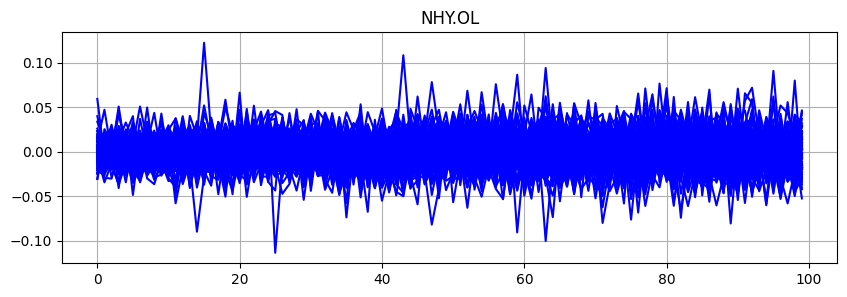

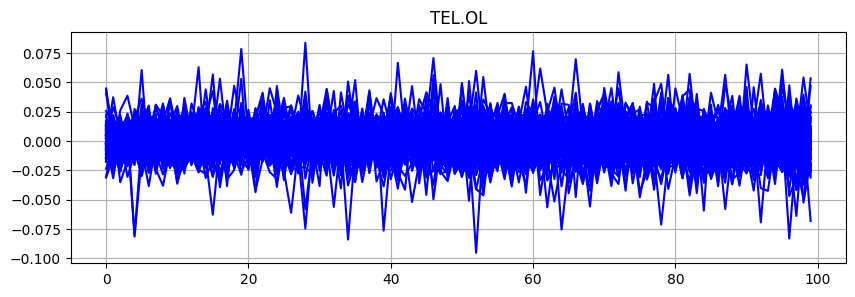

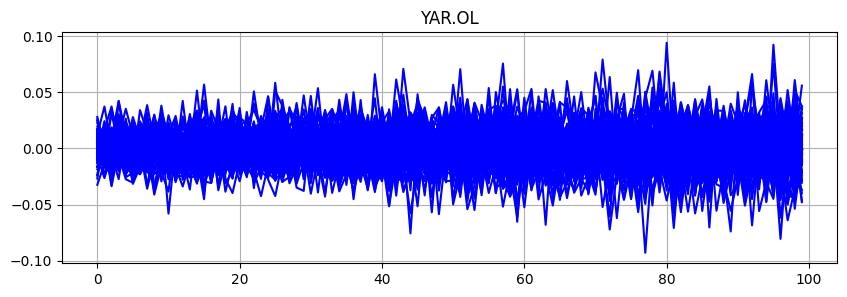

In [35]:
# Look at some forecast
for col in df.columns:
    plt.figure()
    for i in range(n_simulations):
        forecast.get(i)[col].plot(color = 'b', figsize=(10, 3), grid=True, title=col)
    plt.show()